## Preparing the data for recommendation

**The purpose of this part of the project is to select a smaller dataset from the full dataset. It is not meant to be re-run as it was used just once to generate the small dataset**

The functions called in this sections can be found in the `preprocessing.py` and `utils.py` files in the lib folder

In [1]:
from lib import preprocessing as prepro
from lib import utils

### Loading the full data

Before anything else, let us load the dataset

In [2]:
ratings = prepro.load_data('ratings.csv')

Let's take a quick look at how the data is stored in the `DataFrame`:

In [3]:
ratings.head()

,user,item,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


The dataset is constructed as follow :
  - **user** : unique ID of the user
  - **item** : unique ID of the movie
  - **rating** : 1-5 rating of the item


Now that the data is in a proper format, we move on to exploring it a bit and generating the smaller dataset to work with.

### Generating the smaller dataset we are going to work with

As a first step to generate our smaller dataset we will filter out users and items from the full data. In order to so, we need to find thresholds that distinguish candidates from non-candidates to appear in the final dataset, based on the count of ratings they have (both items and users).

Let us first explore the data a bit to get an idea of the **sparsity of the ratings matrix** and its **relative dimensions**. 

Let us take a look at the number of ratings we have:

In [4]:
total_ratings = utils.total_ratings(ratings)
total_ratings

27753444

We have around **27 M ratings** as documented. Let's see how many users and how many items are recorded:

In [5]:
total_users = utils.unique_users(ratings)
total_users

283228

In [6]:
total_items = utils.unique_movies(ratings)
total_items

53889

The ratio of number of item to number of users is:

In [7]:
ratio = utils.shape_matrix_index(ratings)
ratio

0.1902672052198229

Assuming users are row of our matrix and movies are column: the ratings matrix is rather thin but not outrageously so. There are approximately as many movies as a fifth of the number of users.

A **coarse measure of the sparsity** of the matrix is:

In [8]:
sparsity = utils.sparsity_index(ratings)
sparsity

0.9981816370521007

Its value is very close to $1$. The matrix is therefore **extremely sparse**.




#### Exploring the item distribution and sampling items

Let us now look at the **distribution of number of ratings per item** to learn more about the data at hand.

In [9]:
ratings_per_item = prepro.count_ratings(ratings, "item")

In [10]:
ratings_per_item.hist(bins = [i for i in range(0,100)])

As expected, we have a **long tail distribution**. We might have to adapt our evaluation metrics to account for this property and not promote popular content indiscrimately too systematically.

Let us now sample the items we will consider - we sample more than 1000 items because we anticipate a lot items will disappear from the matrix when we filter on users, discarding all users that have rated some movies; especially because of so many movies have a small number of ratings :


In [11]:
ratings = prepro.sampling_data(ratings, "item", 1600, random_state = 0)

Now loooking at the distribution of the sampled items:

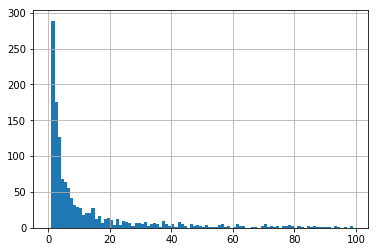

In [12]:
ratings_per_item = prepro.count_ratings(ratings, "item")
ratings_per_item.hist(bins = [i for i in range(0,100)])

We have a similar long-tailed distribution, much more noisy due to the small number of items we kept.

#### Choosing the threshold $user\_min\_rating$ and removing users with very little ratings

Let us now find a suitable $user\_min\_ratings$ and filter out the already-filtered data based on that thresholds on users.

**We will choose $user\_min\_ratings$ according to the following heuristic: choose the threshold such that there are around $100,000$ users that have rated at least $user\_min\_ratings$ movies.** To obtain the $10,000$ users we will have in the final small dataset we will then have to sample from those $100,000$ users, choosing $4\%$ of the candidates.

Now let's take a look at the user distribution on our filtered data:

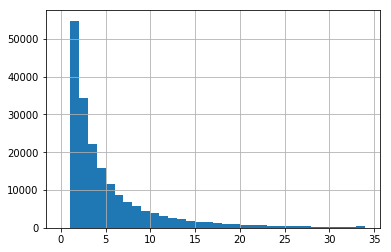

In [13]:
ratings_per_user = prepro.count_ratings(ratings, "user")
ratings_per_user.hist(bins = [i for i in range(0,35)])

Again, a long-tail distribution with a large proportion of users with only one rating.

Let us find the threshold of ratings we will select to obtain near 100,000 user candidates:

In [14]:
user_min_ratings, total_candidates = prepro.find_min_ratings(ratings_per_user, 100000)

In [15]:
user_min_ratings, total_candidates

(3.0, 104432)

**We will consider users that have rated at least 3 movies to sample from.** We ended up with approximately 103,000 candidates to sample from.

In [16]:
filtered_dataset, real = prepro.filter_element(ratings, "user", total_candidates)

In [17]:
final_dataset = prepro.sampling_data(filtered_dataset, "user", 10000, random_state = 0)

We write our final dataset to a `ratings_small.csv` file to use the same data during the development phase of the project.


In [22]:
final_dataset.to_csv('ratings_small.csv', index = False)